In [1]:
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import json
import os
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache
from collections import Counter
from collections import defaultdict
from nltk.corpus import stopwords
from string import punctuation
from matplotlib import pyplot as plt
%matplotlib inline

# Data loading

In [2]:
def get_embeddings(wv_file='wiki.ru.vec'):
    return gensim.models.KeyedVectors.load_word2vec_format(wv_file)

In [3]:
def get_words_to_score(embeddings, max_num=10000):
    words = pd.read_csv('freqrnc2011.csv', sep='\t').sort_values('Freq(ipm)', ascending=False)
    top_words = list(
        set(filter(lambda x: x in embeddings, [x.lower() for x in words[:max_num]['Lemma'].to_numpy()]))
    )
    return top_words

In [4]:
#embeddings = get_embeddings()
#embeddings.iw = get_words_to_score(embeddings)

In [5]:
embeddings_mm = gensim.models.Word2Vec.load('ModelMM.vec')
embeddings_mm.iw = list(embeddings_mm.wv.vocab.keys())

# Seeds

In [6]:
positive_seeds_general = [
    "хороший", "прекрасный", "счастливый", "улучшение", "прогресс", "успех", "добро"
]
negative_seeds_general = [
    "ненависть", "ужасный", "несчастный", "трагедия", "плохой", "зло",
    #"смерть", "ухудшение", "коррупция", "преступление"
]
positive_seeds_kz = [
    'развитие', 'проект', 'программа', 'производство', 'инвестиция',
    'создавать', 'возможность', 'отрасль', 'подписывать', 'модернизация',
    'реализовывать', 'достигать', 'смочь', 'перспектива', 'рождаться'
]
negative_seeds_kz = [
    'отключение', 'незаконно', 'погибать', 'вынуждать', 'преступник',
    'заставлять', 'враг', 'вор', 'ослабление', 'залог',
    'взяточничество', 'махинация', 'поймать', 'халатность',
    #'экстремистский', 'избивать', 'угрожать'
]

In [7]:
positive_seeds = positive_seeds_general + positive_seeds_kz
negative_seeds = negative_seeds_general + negative_seeds_kz

# Words scoring

In [8]:
def get_edge_matrix(embeddings, k=25):
    A = np.array([embeddings[word] for word in embeddings.iw])
    T = cosine_similarity(A)
    T = np.arccos(np.clip(-T, -1, 1)) / np.pi
    def knn(vec, k=k):
        vec[vec < np.sort(vec)[-k]] = 0.
    np.fill_diagonal(T, 0)
    np.apply_along_axis(knn, 1, T)
    return T

In [9]:
#@lru_cache(maxsize=1, typed=False)
def transition_matrix(embeddings):
    edge_matrix = get_edge_matrix(embeddings)
    scale_matrix = np.diag([1. / np.sqrt(edge_matrix[i].sum())
                            if edge_matrix[i].sum() > 0. else 0.
                            for i in range(edge_matrix.shape[0])])
    return np.dot(scale_matrix, np.dot(edge_matrix, scale_matrix))

In [10]:
def run_walk(tr_matrix, pol_vector, beta, max_iter, eps):
    loss = 0
    vector = np.ones(tr_matrix.shape[0]) / tr_matrix.shape[0]
    for i in range(max_iter):
        new_vector = beta * np.dot(tr_matrix, vector) + (1 - beta) * pol_vector
        loss = np.abs(new_vector - vector).sum()
        if loss < eps:
            break
        vector = new_vector
    return vector

In [11]:
def get_walk_start_vector(words, seeds):
    return np.array([seeds[word] if word in seeds else 0.0 for word in words]) / len(seeds)

In [12]:
def random_walk(embeddings, positive_seeds, negative_seeds, beta=0.9, max_iter=1000, eps=1e-6):
    if not type(positive_seeds) == dict:
        positive_seeds = {word: 1.0 for word in positive_seeds}

    if not type(negative_seeds) == dict:
        negative_seeds = {word: 1.0 for word in negative_seeds}

    words = embeddings.iw
    tr_matrix = transition_matrix(embeddings)
    pos_pol = run_walk(tr_matrix, get_walk_start_vector(words, positive_seeds), beta, max_iter, eps)
    neg_pol = run_walk(tr_matrix, get_walk_start_vector(words, negative_seeds), beta, max_iter, eps)
    score = {w: pos_pol[i] / (neg_pol[i] + pos_pol[i]) if neg_pol[i] + pos_pol[i] > 0 else 0 for i, w in enumerate(words)}
    return pos_pol, neg_pol, score

In [13]:
#pos_pol, neg_pol, word_scores = random_walk(embeddings, positive_seeds, negative_seeds)

In [14]:
mm_pos_pol, mm_neg_pol, mm_word_scores = random_walk(embeddings_mm, positive_seeds, negative_seeds)

/Users/let4ik/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [15]:
def normalize(scores, max_neg=0, min_pos=0):
    normalized = dict()
    val = np.array(list(scores.values()))
    mn = np.mean(val)
    for text, score in scores.items():
        normalized[text] = scores[text] - mn
        if max_neg < normalized[text] < min_pos:
            normalized[text] = 0
    sns.distplot(list(filter(lambda x: x != 0, normalized.values())))
    return mn, normalized

In [16]:
#sns.distplot(list(mm_word_scores.values()))

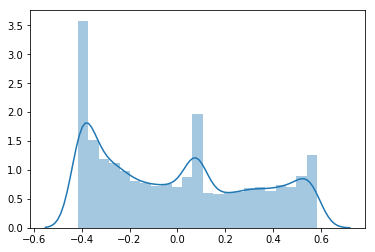

In [17]:
#d_mean_, nword_scores = normalize(word_scores)
mm_mean, nmm_word_scores = normalize(mm_word_scores)

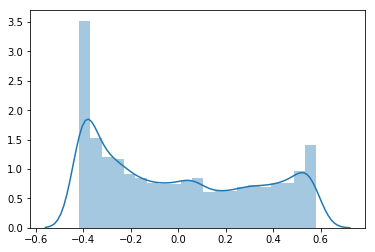

In [18]:
mm_ne_word_scores = dict()
for word, score in mm_word_scores.items():
    if word.startswith('не_') and word[3:] in mm_word_scores:
        mm_ne_word_scores[word] = 1 - mm_word_scores[word[3:]]
    else:
        mm_ne_word_scores[word] = score
mm_ne_mean, nmm_ne_word_scores = normalize(mm_ne_word_scores)

In [19]:
#ne_word_scores = dict()
#for word, score in word_scores.items():
#    ne_word_scores['не_' + word] = 1 - word_scores[word]
#    ne_word_scores[word] = word_scores[word]
#ne_mean, nne_word_scores = normalize(ne_word_scores)

### Kazakhstan

In [20]:
def get_kz_text():
    
    kz = pd.read_csv('kazakh_train.csv').iloc[:, [1, 2]].to_numpy()
        
    kpos = list(map(lambda x: x[0], filter(lambda x: x[1] == 1, kz)))
    kneg = list(map(lambda x: x[0], filter(lambda x: x[1] == 2, kz)))

    texts = list(map(lambda x: x[0], kz))
    return kpos, kneg, texts, kz

def get_words_stat(kpos, kneg):
    pos_words = ' '.join(kpos).split(' ')
    neg_words = ' '.join(kneg).split(' ')
    pos_cnt = Counter(pos_words)
    neg_cnt = Counter(neg_words)
    word_score = dict()
    for word in set(pos_words + neg_words):
        word_score[word] = pos_cnt[word] - neg_cnt[word]
    return words_score

In [21]:
kpos, kneg, kall, klb = get_kz_text()

# Mediametrics

In [22]:
def get_mm_texts(filename):
    return pd.read_csv(filename)

mm_data = get_mm_texts('mm_v2.csv')
mm_data_reg = get_mm_texts('mm.csv')

In [23]:
mm_dreg = defaultdict(list)
mm_dreg_ind = defaultdict(list)
for ind, text in enumerate(mm_data.iloc[:,1].to_numpy()):
    mm_dreg[mm_data_reg.iloc[ind, 7]].append(text)
    mm_dreg_ind[mm_data_reg.iloc[ind, 7]].append(ind)

In [24]:
mm_texts = [text for reg in mm_dreg.keys() for text in mm_dreg[reg] if not pd.isnull(text)]

# News scoring

In [25]:
def get_tfidf(kpos, kneg=[]):
    tfidf = TfidfVectorizer()
    tfidf.fit(kpos + kneg)
    return dict([(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

In [26]:
#tfidf = get_tfidf(kall)

In [27]:
mm_tfidf = get_tfidf(mm_texts)

In [28]:
def get_text_score(text, wrd_scores=None, w=None, activation=None):
    if wrd_scores is None:
        wrd_scores = mm_word_scores
    if activation is None:
        activation = lambda x: x
    score = 0
    cnt = 0
    for word in text.split():
        if word in wrd_scores:
            if w is None:
                score += activation(wrd_scores[word])
                cnt += 1
            elif word in w:
                score += activation(wrd_scores[word]) * w[word]
                cnt += 1
    return score / cnt if cnt > 0 else 0

In [29]:
def get_scores(texts, wrd_scores=None, w=None, activation=None):
    scores = []
    for ind, text in enumerate(texts):
        if not pd.isnull(text):
            scores.append((ind, get_text_score(text, wrd_scores, w=w, activation=activation)))
        else:
            scores.append((ind, np.nan))
    return scores

In [30]:
def analyze_texts(texts, top_pos=10, top_neg=10, wrd_scores=None, w=None, activation=None, plot=True):
    scores = get_scores(texts, wrd_scores, w=w, activation=activation)
    scores_sorted = list(sorted(scores, key=lambda x: x[1]))
    if plot:
        sns.distplot(list(filter(lambda x: not np.isnan(x), map(lambda x: x[1], scores))))
    return scores, scores_sorted[:top_neg], scores_sorted[-top_pos:]

In [31]:
def compare_scores(first, second, wrd_scores=None, w=None, activation=None):
    analyze_texts(first, wrd_scores=wrd_scores, w=w, activation=activation)
    analyze_texts(second, wrd_scores=wrd_scores, w=w, activation=activation)
    plt.show()

In [32]:
def analyze_news(reg_texts, wrd_scores=None, w=None, activation=None, plot=True):
    res_sc = dict()
    res_mean = dict()
    for reg, texts in reg_texts.items():
        res_sc[reg] = list(map(lambda x: x[1], analyze_texts(texts, wrd_scores=wrd_scores, w=w, activation=activation, plot=False)[0]))
        res_mean[reg] = np.nanmean(np.asarray(res_sc[reg]))
    if plot:
        sns.distplot(list(res_mean.values()))
        plt.show()
    return res_mean, res_sc

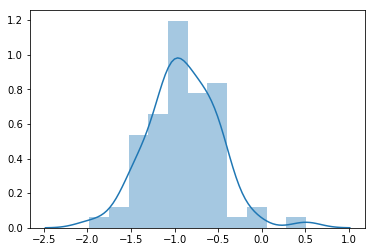

In [33]:
res_mean, res_sc = analyze_news(
    mm_dreg,
    wrd_scores=nmm_ne_word_scores,
    w=None, 
    activation=lambda x: np.tan(np.pi * (x - 0.1) / 1.1)
)

In [34]:
res_sc_idx = []
for reg in res_sc:
    for ind, sc in enumerate(res_sc[reg]):
        res_sc_idx.append((mm_dreg_ind[reg][ind], sc))

res_sc_idx = list(sorted(res_sc_idx, key=lambda x: x[0]))

In [35]:
tmp_hh = list(map(lambda x: x[0], sorted(res_sc_idx, key=lambda x: x[1])))

In [36]:
res_df = pd.DataFrame.from_records(res_sc_idx)

In [37]:
res_df.to_csv('scores_news_ne.csv')

In [ ]:
all_msk, neg_msk, pos_msk = analyze_texts(
    mm_dreg['г.москва'],
    top_pos=2000,
    top_neg=2000,
    wrd_scores=nmm_ne_word_scores,
    w=None, 
    activation=lambda x: np.tan(np.pi * (x - 0.1) / 1.1)
)

In [ ]:
for idx, sc in pos_msk[-100:]:
    text = mm_dreg['г.москва'][idx]
    if not pd.isnull(text) and len(text.split()) < 4:
        continue
    print(text)